# Mice data analysis

In [170]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import scipy
import requests
import xlrd
import urllib
from scipy.stats import f_oneway
from scipy import stats
from itertools import combinations

In [196]:
from sklearn import linear_model

In [290]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
warnings.filterwarnings("ignore")
np.random.seed(42)

### Downloading the source file from URL

In [136]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
file_name, headers = urllib.request.urlretrieve(url)
workbook = xlrd.open_workbook(file_name)

In [ ]:
## Open the file

In [137]:
train_initial = pd.read_excel(file_name) 

In [140]:
train_initial

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s


# Dataset description

In [145]:
len(train_initial["MouseID"].unique())

1080

In [155]:
train_initial['class'].value_counts() # according to class

c-CS-m    150
c-SC-m    150
c-CS-s    135
t-SC-m    135
t-SC-s    135
c-SC-s    135
t-CS-m    135
t-CS-s    105
Name: class, dtype: int64

In [156]:
train_initial['Genotype'].value_counts() # according to genotype - control wild-type or not

Control    570
Ts65Dn     510
Name: Genotype, dtype: int64

In [9]:
train_initial.isnull().sum(axis=1).tolist().count(0)

552

# 2. Есть ли различия в уровне продукции BDNF_N в зависимости от класса в эксперименте (10 баллов)

In [157]:
cols = train_initial.columns
train_initial[cols] = train_initial[cols].fillna(train_initial[cols].median())

In [158]:
train_numeric = train_initial.iloc[:, 1:-4]

In [159]:
class_group = train_initial.groupby('class', as_index=False)['BDNF_N'].agg(['mean', 'std', "median"])

In [160]:
class_group

,mean,std,median
class,,,
c-CS-m,0.339217,0.046883,0.333664
c-CS-s,0.342315,0.054885,0.340390
c-SC-m,0.290946,0.038587,0.291883
c-SC-s,0.313393,0.043637,0.314812
t-CS-m,0.312732,0.051175,0.317112
t-CS-s,0.305460,0.043350,0.295108
t-SC-m,0.321063,0.033216,0.318074
t-SC-s,0.325386,0.056912,0.320348


In [161]:
menMeans = class_group["mean"].tolist()
menStd = class_group["std"].tolist()

Text(0, 0.5, 'BDNF_N production level')

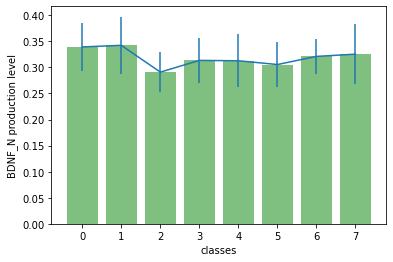

In [178]:
ind  = np.arange(8)    # the x locations for the groups
width= 0.7
labels = train_initial['class'].unique().tolist()

fig, ax = plt.subplots()
ax.p1 = plt.bar(ind, menMeans, alpha = 0.5, color = "green") 
ax.errs = plt.errorbar(ind, menMeans, yerr=menStd)
plt.xlabel("classes")
plt.ylabel("BDNF_N production level")

In [164]:
class1 = train_initial[train_initial["class"] == "c-CS-m"]["BDNF_N"].tolist()
class2 = train_initial[train_initial["class"] == "c-CS-s"]["BDNF_N"].tolist()
class3 = train_initial[train_initial["class"] == "c-SC-m"]["BDNF_N"].tolist()
class4 = train_initial[train_initial["class"] == "c-SC-s"]["BDNF_N"].tolist()
class6 = train_initial[train_initial["class"] == "t-CS-s"]["BDNF_N"].tolist()
class7 = train_initial[train_initial["class"] == "t-SC-m"]["BDNF_N"].tolist()
class8 = train_initial[train_initial["class"] == "t-SC-s"]["BDNF_N"].tolist()

In [165]:
stats.kruskal(class1, class2, class3, class4, class5, class6, class7, class8)

KruskalResult(statistic=120.95928749413135, pvalue=4.836076278909325e-23)

In [166]:
f_oneway(class1, class2, class3, class4, class5, class6, class7, class8)

F_onewayResult(statistic=18.85252918272042, pvalue=7.867561257255377e-24)

In [167]:
scipy.stats.ttest_ind(class2, class3)

Ttest_indResult(statistic=9.210192900891245, pvalue=7.557427491315519e-18)

In [171]:
classes = [class1, class2, class3, class4, class5, class6, class7, class8]

In [172]:
df_list = [scipy.stats.ttest_ind(i, j) for i, j in combinations(classes, 2)]


In [173]:
for i in range(len(df_list)):
    if df_list[i][1] < 0.01:
        print(df_list[i][1])

1.246345121555186e-19
2.6035488522408673e-06
7.636238215679812e-06
1.6364260278332648e-08
0.00022801957586784724
7.557427491315519e-18
2.730716645883316e-06
7.114813172166865e-06
4.67482703508521e-08
0.00014836507553949937
6.14048871619675e-06
5.8147013527552394e-05
0.005361086915083205
1.6078657732623992e-11
5.1004973683411765e-09
0.0017976946891108893
0.0032051170444152214


In [174]:
X_train, X_test, y_train, y_test = train_test_split (train_numeric, train_numeric["ERBB4_N"], train_size = 0.6, random_state=10)

### Standartization of the train data

In [179]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [197]:
reg = linear_model.LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)

# 4. Сделайте PCA (15 баллов)

### PCA with all components

In [293]:
X_train, X_test, y_train, y_test = train_test_split(train_numeric, train_numeric["ERBB4_N"], train_size = 0.7, random_state=50)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = X_train.shape[1])
#pca.fit(X_train)
X_train = pca.fit_transform (X_train)
X_test = pca.transform (X_test)
reg = LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)

Text(0, 0.5, 'pc2')

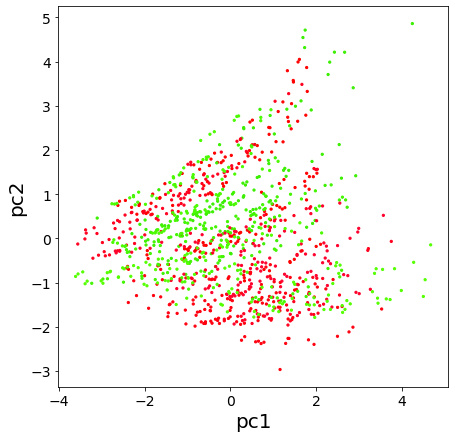

In [305]:
## plotting two components 
pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(train_numeric)

df1 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

train_initial['class']=pd.Categorical(train_initial['class'])
my_color=train_initial["class"].cat.codes 

plt.figure(figsize=(7,7))
plt.scatter(df1['principal component 1'], df1['principal component 2'], c=my_color, cmap='prism', s =5)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [306]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

1.0 1.0


In [238]:
np.cumsum (pca.explained_variance_ratio_)

array([0.25466093, 0.42602126, 0.52729609, 0.60390154, 0.65453625,
       0.70024594, 0.73681657, 0.76804817, 0.79105465, 0.80848422,
       0.82385486, 0.83662483, 0.84840207, 0.85919356, 0.8689942 ,
       0.87750486, 0.88569472, 0.89311779, 0.8998567 , 0.90597694,
       0.91152927, 0.91669212, 0.92162746, 0.92635084, 0.93095681,
       0.93507063, 0.9390545 , 0.94264944, 0.94602095, 0.94928407,
       0.95227508, 0.95505705, 0.95773498, 0.96024624, 0.96259077,
       0.96480607, 0.96690041, 0.96891759, 0.97083579, 0.97263062,
       0.97434557, 0.97590695, 0.97738186, 0.97882403, 0.98018854,
       0.98153649, 0.98275297, 0.98396441, 0.98513387, 0.98622077,
       0.98728287, 0.98826934, 0.98913578, 0.98999037, 0.9908092 ,
       0.99158843, 0.99231544, 0.99298832, 0.99365389, 0.994289  ,
       0.99488193, 0.99544417, 0.99597916, 0.9964791 , 0.99693146,
       0.99735677, 0.99776817, 0.9981577 , 0.99849689, 0.99881242,
       0.99911269, 0.99936137, 0.99956597, 0.99974707, 0.99987

In [240]:
pca.explained_variance_ratio_

array([2.54660926e-01, 1.71360330e-01, 1.01274833e-01, 7.66054507e-02,
       5.06347073e-02, 4.57096910e-02, 3.65706375e-02, 3.12315979e-02,
       2.30064801e-02, 1.74295639e-02, 1.53706427e-02, 1.27699713e-02,
       1.17772374e-02, 1.07914897e-02, 9.80064440e-03, 8.51066077e-03,
       8.18985542e-03, 7.42307087e-03, 6.73890881e-03, 6.12024516e-03,
       5.55233090e-03, 5.16284561e-03, 4.93534267e-03, 4.72337362e-03,
       4.60597713e-03, 4.11382066e-03, 3.98386611e-03, 3.59493964e-03,
       3.37151483e-03, 3.26311794e-03, 2.99100776e-03, 2.78197372e-03,
       2.67792929e-03, 2.51125225e-03, 2.34453118e-03, 2.21530745e-03,
       2.09433259e-03, 2.01718278e-03, 1.91820210e-03, 1.79483144e-03,
       1.71495022e-03, 1.56138008e-03, 1.47490816e-03, 1.44216452e-03,
       1.36451687e-03, 1.34795060e-03, 1.21647455e-03, 1.21144262e-03,
       1.16945823e-03, 1.08690057e-03, 1.06210030e-03, 9.86467657e-04,
       8.66447646e-04, 8.54582818e-04, 8.18837274e-04, 7.79224610e-04,
      

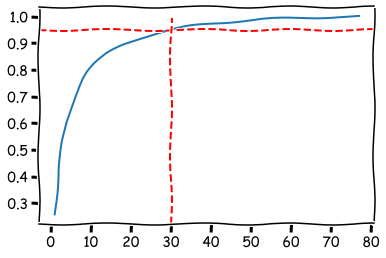

In [205]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

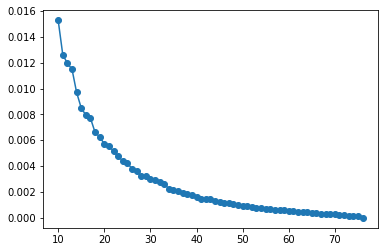

In [206]:
plt.scatter(np.arange(10, 77), pca.explained_variance_ratio_[10:77])
plt.plot(np.arange(10, 77), pca.explained_variance_ratio_[10:77])
plt.show()

In [207]:
#Third option:

In [208]:
def shuffle_dataset(dataset):
    """
    Мешаем данные
    """
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для перемешанных данных
    """
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
        
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для реальных данных
    """
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    
    return pca.explained_variance_ratio_


# Дальше идет ряд графиков для визуализации

def plot_mean_and_ci(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_ci(ax, variance_by_chance, label="chance", color_mean="red", color_shading="red")


def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ratio", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

    
def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)


def calc_permutat_pval(real_values, permut_values, eps=None):
    """
    Сравниваем долю объясненной дисперсии для реальных данных и для перемешанных
    """
    eps = eps or (1 / (permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    """
    Главная функция, которая просто запускает все, что выше
    """
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

<ipython-input-208-4800d10539b4>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(n_replics)):


0 iter



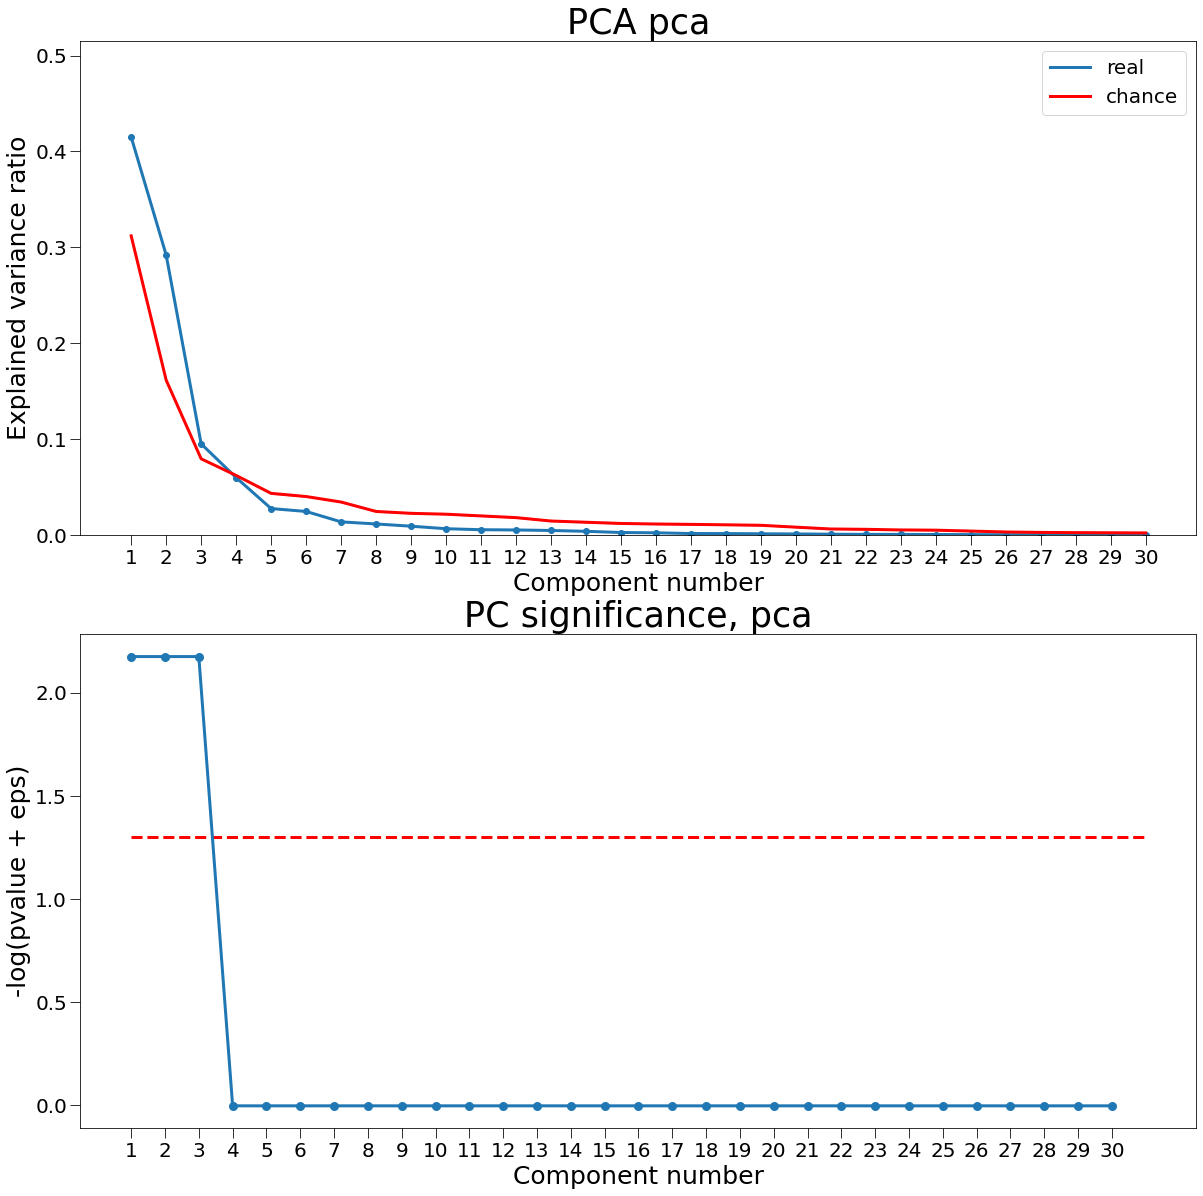

In [209]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, train_numeric, "pca", n_replics=15, n_components=30)

From those pictures it seems like the needed component number is 4.

Checking for the number of components 4:
Standartization -> PCA -> Regression Model

In [232]:
X_train, X_test, y_train, y_test = train_test_split(train_numeric, train_numeric["ERBB4_N"], train_size = 0.7, random_state=50)
sc = StandardScaler()
#sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = 4)
#pca.fit(X_train)
X_train = pca.fit_transform (X_train)
X_test = pca.transform (X_test)
reg = linear_model.LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)


In [233]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

0.6865124391233999 0.6848427317419


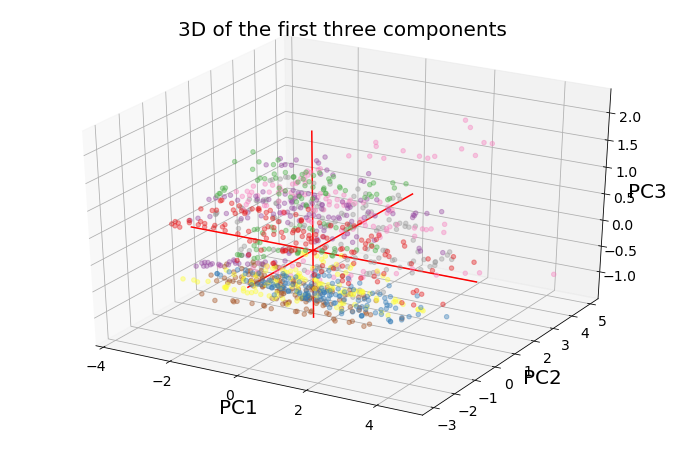

In [292]:
df = train_numeric
pca = PCA(n_components=3)
pca.fit(df)
train_initial['class']=pd.Categorical(train_initial['class'])
my_color=train_initial["class"].cat.codes 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)])
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set1_r", s=20, alpha=0.4)

# make  axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D of the first three components")
plt.show()